In [2]:
from openfermion.hamiltonians import MolecularData, load_molecular_hamiltonian
from openfermion.ops import FermionOperator
from openfermion.transforms import bravyi_kitaev
from openfermion.utils import hermitian_conjugated
from openfermion.ops import QubitOperator
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from scipy.optimize import minimize
from pyquil import Program
from pyquil.gates import *

import numpy as np
import functools

import matplotlib.pyplot as plt
%matplotlib inline

from openfermion.utils import uccsd_generator
from forestopenfermion import exponentiate


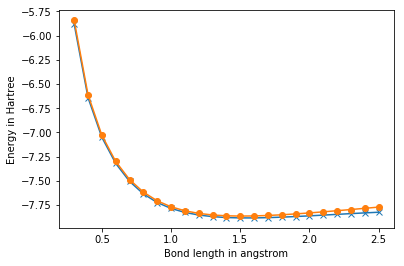

In [2]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
bond_length_interval = 0.1
n_points = 25

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for point in range(3, n_points + 1):
    bond_length = bond_length_interval * point
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
#    print(description)
    geometry = [('H', (0., 0., 0.)), ('Li', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()

    # Print out some results of calculation.
#    print('\nAt bond length of {} angstrom, molecular hydrogen has:'.format(
#        bond_length))
#    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
#    print('MP2 energy of {} Hartree.'.format(molecule.mp2_energy))
#    print('FCI energy of {} Hartree.'.format(molecule.fci_energy))
#    print('Nuclear repulsion energy between protons is {} Hartree.'.format(
#        molecule.nuclear_repulsion))
#    for orbital in range(molecule.n_orbitals):
#        print('Spatial orbital {} has energy of {} Hartree.'.format(
#            orbital, molecule.orbital_energies[orbital]))
    hf_energies += [molecule.hf_energy]
    fci_energies += [molecule.fci_energy]

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'x-')
plt.plot(bond_lengths, hf_energies, 'o-')
#plt.plot(bond_lengths, vqe_ground_energies, 'o-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

In [3]:
sim = WavefunctionSimulator()
numQubit = 12

def solve_vqe(hamiltonian: PauliSum, numLayer) -> float:
    # Construct a variational quantum eigensolver solution to find the lowest
    # eigenvalue of the given hamiltonian
    theta_init = np.random.rand(2*numQubit*numLayer) * 2 * np.pi

    def ansatz_energy(theta_vec):
        p = None
        p = Program()
        for j in range(numLayer):
            for i in range(numQubit):
                p += RX(theta_vec[2*numQubit * j + 2 * i], i)
                p += RZ(theta_vec[2*numQubit * j + 2 * i + 1], i)
            for i in range(numQubit - 1):
                p += CNOT(i, i + 1)

        energy = sim.expectation(p, hamiltonian).real
        return energy

    theta_answer = minimize(ansatz_energy, theta_init, method='L-BFGS-B').x
    return ansatz_energy(theta_answer)

def get_ground_energy(interaction_hamil, numLayer):
    fermionop_hamil = FermionOperator()
    for key in interaction_hamil:
        value = interaction_hamil[key]
        fermionop_hamil += FermionOperator(term=key, coefficient=value)
        
    qubitop_hamil = bravyi_kitaev(fermionop_hamil)
    pauliop_hamil = qubitop_to_pyquilpauli(qubitop_hamil)
    
    sim = WavefunctionSimulator()
    return solve_vqe(pauliop_hamil, numLayer)


In [8]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.4, 8)
vqe_ground_energies = []

for bond_length in bond_lengths:
    geometry = [('H', (0., 0., 0.)), ('Li', (0., 0., bond_length))]
    description = str(round(bond_length, 2))
    LiH_interaction_hamil = load_molecular_hamiltonian(geometry,
        basis,
        multiplicity,
        description,
        n_active_electrons=None,
        n_active_orbitals=None)
    
    ge = get_ground_energy(LiH_interaction_hamil, 12, 1)
    vqe_ground_energies.append(ge)
    print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge)

print(vqe_ground_energies)

bond length:  0.3  ground state energy:  -5.661920669530375
bond length:  0.6  ground state energy:  -6.857139585102836
bond length:  0.9  ground state energy:  -6.981458553855431
bond length:  1.2  ground state energy:  -7.52262132276858
bond length:  1.5  ground state energy:  -7.256650561887416
bond length:  1.8  ground state energy:  -7.65683809436335
bond length:  2.1  ground state energy:  -7.269666894649319
bond length:  2.4  ground state energy:  -7.343334437082872
[-5.661920669530375, -6.857139585102836, -6.981458553855431, -7.52262132276858, -7.256650561887416, -7.65683809436335, -7.269666894649319, -7.343334437082872]


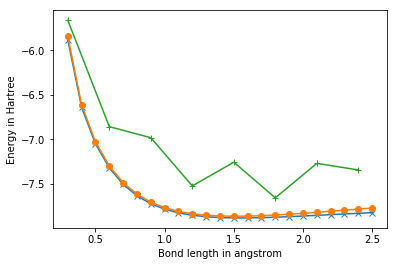

In [11]:
bond_lengths_1 = bond_length_interval * np.array(range(3, n_points + 1))
bond_lengths_2 = bond_lengths = np.linspace(0.3, 2.4, 8)

plt.figure(0)
plt.plot(bond_lengths_1, fci_energies, 'x-')
plt.plot(bond_lengths_1, hf_energies, 'o-')
plt.plot(bond_lengths_2, vqe_ground_energies, '+-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

In [4]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.4, 8)
vqe_ground_energies = []

for bond_length in bond_lengths:
    geometry = [('H', (0., 0., 0.)), ('Li', (0., 0., bond_length))]
    description = str(round(bond_length, 2))
    LiH_interaction_hamil = load_molecular_hamiltonian(geometry,
        basis,
        multiplicity,
        description,
        n_active_electrons=None,
        n_active_orbitals=None)
    
    ge = get_ground_energy(LiH_interaction_hamil, 12, 2)
    vqe_ground_energies.append(ge)
    print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge)

print(vqe_ground_energies)

bond length:  0.3  ground state energy:  -5.643333597151743
bond length:  0.6  ground state energy:  -6.905621177769708
bond length:  0.9  ground state energy:  -6.244260785510037
bond length:  1.2  ground state energy:  -7.680866341307884
bond length:  1.5  ground state energy:  -7.705289569283017
bond length:  1.8  ground state energy:  -7.724768757519198
bond length:  2.1  ground state energy:  -7.078660331853706
bond length:  2.4  ground state energy:  -7.309488230875521


NameError: name 'vqe_ground_energies_layer2' is not defined

In [5]:
print(vqe_ground_energies)

[-5.643333597151743, -6.905621177769708, -6.244260785510037, -7.680866341307884, -7.705289569283017, -7.724768757519198, -7.078660331853706, -7.309488230875521]


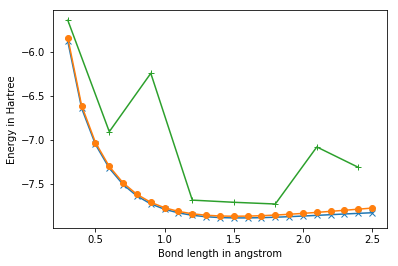

In [6]:
bond_lengths_1 = bond_length_interval * np.array(range(3, n_points + 1))
bond_lengths_2 = bond_lengths = np.linspace(0.3, 2.4, 8)

plt.figure(0)
plt.plot(bond_lengths_1, fci_energies, 'x-')
plt.plot(bond_lengths_1, hf_energies, 'o-')
plt.plot(bond_lengths_2, vqe_ground_energies, '+-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

In [5]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.4, 8)
vqe_ground_energies_layer4 = []

for bond_length in bond_lengths:
    geometry = [('H', (0., 0., 0.)), ('Li', (0., 0., bond_length))]
    description = str(round(bond_length, 2))
    LiH_interaction_hamil = load_molecular_hamiltonian(geometry,
        basis,
        multiplicity,
        description,
        n_active_electrons=None,
        n_active_orbitals=None)
    
    ge = get_ground_energy(LiH_interaction_hamil, 4)
    vqe_ground_energies_layer4.append(ge)
    print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge)

print(vqe_ground_energies_layer4)

KeyboardInterrupt: 